# Data preparation 
This notebook is the code I used to prepare the data for the full ~2.4TB Danbooru2018 dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import json
from pathlib import Path
import os
from fastai.core import parallel
import pickle
import gc
    
def inner(pths, i):
    inner_lab = {}
    pth, image_dir = pths
    image_dir = Path(image_dir)
    with open(pth, "r") as f:
        for line in f:
            example = json.loads(line)
            idd = example['id']
            f1 = "{:04d}".format((int(idd) % 1000))

            poth = image_dir/f1/(str(idd) + '.' + str(example['file_ext']))
            example['path'] = poth
            if poth.is_file():
                inner_lab[idd] = example
            else:
                continue
    with open(pth.parent/(pth.stem + 'tmp.pkl'), 'wb') as handle:
        pickle.dump(inner_lab, handle, protocol=pickle.HIGHEST_PROTOCOL)

def filter_labels(metadata_dir, image_dir):
    """ 
    Filters and merges all metadata in `metadata_dir` into a single json object,
    consisting of only the images you have in `image_dir`
    """
    meta_paths = [i for i in Path(metadata_dir).glob('**/*') if i.is_file()]
    meta_paths = [i for i in meta_paths if 'tmp' not in i.name]
    
    labels = {}
    
    col = [(pth, image_dir) for pth in meta_paths]
#     parallel(inner, col)

    return col
    
    #finished_paths = Path(metadata_dir).glob('*tmp.pkl')
    #for pth in finished_paths:
    #    with open(pth, 'rb') as handle:
    #        labels.update(pickle.load(handle))
    #    os.remove(pth)
        
    #return labels

col = filter_labels('danbooru2018/metadata/', 'danbooru2018/original/')
print(len(col))

34


Due to the size of the metadata and the number of files involved for the full dataset, I had to do this slowly with maximum two workers otherwise bad errors came for me.

In [40]:
gc.collect()
parallel(inner, col[32:], max_workers=2)

print("Done ", col[32:])

Done  [(PosixPath('danbooru2018/metadata/2018000000000015'), 'danbooru2018/original/'), (PosixPath('danbooru2018/metadata/2018000000000016'), 'danbooru2018/original/')]


In [5]:
finished_paths = list(Path('danbooru2018/metadata/').glob('**/*tmp.pkl'))
finished_paths = sorted(finished_paths, key=lambda x: x.name)
# print(finished_paths)
labels = {}

# for pth in finished_paths[0:10]:
#     with open(pth, 'rb') as handle:
#         labels.update(pickle.load(handle))

In [11]:
# Don't try this with less than 24GB of ram.
gc.collect()
for pth in finished_paths[20:]:
    with open(pth, 'rb') as handle:
        labels.update(pickle.load(handle))

In [15]:
len(labels)

3331510

In [12]:
with open('filtered_labels.pkl', 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Getting CSV labels of top 6000 tags

In [ ]:
import pandas as pd

meme = {'filename': [], 'tags': []}
total = len(labels)
# togos = set()
img_dir = Path('danbooru2018/original')

for cnt, l in enumerate(labels):
    idd = labels[l]['id']
    f1 = "{:04d}".format((int(idd) % 1000))
    if labels[l]['file_ext'] not in ['jpg', 'png']:
        continue
    poth = img_dir/f1/(str(idd) + '.' + str(labels[l]['file_ext']))
    
    tags = labels[l]['tags']
    tags = [t['name'] for t in tags if t['name'] != '?']
    tags.append('age_rating_' + str(labels[l]['rating']))
    if len(labels[l]['score']) == 1:
        tags.append('meta_score_' + str(labels[l]['score']))
    
#     togos = togos.union(set(tags))
    tags = ' '.join(tags)
    meme['filename'].append(poth)
    meme['tags'].append(tags)
    
    if cnt % 100000 == 0:
        print("{:d} of {:d} | {:3.1f}%".format(cnt, total, 100*cnt/total))

df = pd.DataFrame(meme)
df.head()

In [18]:
df.to_csv('tag_labels_all.csv', index=False)

In [ ]:
import pandas as pd
from pathlib import Path
import pickle
df = pd.read_csv('tag_labels_all.csv')

max_tag_chars = 1600

if Path('class_names.pkl').is_file():
    with open('class_names.pkl','rb') as f: total_cnt = pickle.load(f)
else:
    total_cnt = pd.Series(' '.join(df['tags']).lower().split()).value_counts()

def filter_to_tags(dataframe, tags):
    total = len(dataframe)
    for index, row in dataframe.iterrows():
        if row.isna().sum() > 0:
            print("Detected na row {:}, skipping".format(row))
            continue
        
        tmp = row['tags'].lower().split()
        tmp = [t for t in tmp if t in tags]
        tmp = sorted(tmp, key=lambda x: tags[x], reverse=True)
        while len(' '.join(tmp)) > max_tag_chars:
            del tmp[-1]

        row['tags'] = ' '.join(tmp)
        if index % 20000 == 0:
            print("{:d} of {:d} | {:3.1f}%".format(index, total, 100*index/total))
    
    print("Total na = ", dataframe.isna().sum())
    dataframe = dataframe.dropna(axis=0)
    
    return dataframe

print("Total unique labels = ", len(total_cnt))

df2 = filter_to_tags(df.copy(), total_cnt[0:6000])
df2 = df2.dropna(axis=0)
df2.to_csv('tag_labels_6000.csv', index=False)

# df3 = filter_to_tags(df.copy(), total_cnt[0:200])
# df3.to_csv('tag_labels_200.csv', index=False)
# df4 = filter_to_tags(df.copy(), total_cnt[0:500])
# df4.to_csv('tag_labels_500.csv', index=False)

Total unique labels =  6000
0 of 3294277 | 0.0%
20000 of 3294277 | 0.6%
40000 of 3294277 | 1.2%
60000 of 3294277 | 1.8%
80000 of 3294277 | 2.4%
100000 of 3294277 | 3.0%
120000 of 3294277 | 3.6%
140000 of 3294277 | 4.2%
160000 of 3294277 | 4.9%
180000 of 3294277 | 5.5%
200000 of 3294277 | 6.1%
220000 of 3294277 | 6.7%
240000 of 3294277 | 7.3%
260000 of 3294277 | 7.9%
280000 of 3294277 | 8.5%
300000 of 3294277 | 9.1%
320000 of 3294277 | 9.7%
340000 of 3294277 | 10.3%
360000 of 3294277 | 10.9%
380000 of 3294277 | 11.5%
400000 of 3294277 | 12.1%
420000 of 3294277 | 12.7%
440000 of 3294277 | 13.4%
460000 of 3294277 | 14.0%
480000 of 3294277 | 14.6%
500000 of 3294277 | 15.2%
520000 of 3294277 | 15.8%
540000 of 3294277 | 16.4%
560000 of 3294277 | 17.0%
580000 of 3294277 | 17.6%
600000 of 3294277 | 18.2%
620000 of 3294277 | 18.8%
640000 of 3294277 | 19.4%
660000 of 3294277 | 20.0%
680000 of 3294277 | 20.6%
700000 of 3294277 | 21.2%
720000 of 3294277 | 21.9%
740000 of 3294277 | 22.5%
760000 of 

In [14]:
import pickle
with open('class_names.pkl','wb') as f: pickle.dump(total_cnt[0:6000], f)
# to get just list of names, use: 
# with open('class_names.pkl','rb') as f: classes = pickle.load(f).index.tolist()

In [16]:
df = pd.read_csv('tag_labels_6000.csv')
kkk = df.iloc[:, 1]
# df = df.dropna(axis=0)
# df.to_csv('tag_labels_6000.csv', index=False)

# Tag clipping
Look in the histogram below, there is a long-tail distribution of the amount of tags. So to keep memory requirements somewhat realistic, I clipped the max length to be a more reasonable number or chars

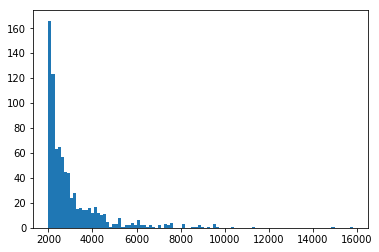

In [76]:
# lol = kkk.str.len().max()
# lol = lol[lol > 2000]
plt.hist(lol, bins=100)
plt.show()